In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

from tqdm import tqdm

In [2]:
torch.device('cuda')

device(type='cuda')

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output


In [4]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [8]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, device):
        super(Transformer, self).__init__()
        self.device = device
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2).to(self.device)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3).to(self.device)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask.to(self.device)

        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [9]:
src_vocab_size = 1000
tgt_vocab_size = 2000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 50
dropout = 0.1
device = "cpu"

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout,  device)
transformer = transformer.to(device)

In [10]:
# start_token = torch.tensor([1999], dtype=torch.int64)

In [11]:
from random import randint

In [12]:
def generate_sample():
    start = randint(1, 500)
    extra = 10

    src = torch.arange(start, start+max_seq_length+extra, dtype=torch.int64)
    trg = src + torch.arange(1, max_seq_length+extra+1, dtype=torch.int64)
    labels = trg[1:]

    return src[:max_seq_length], trg[:max_seq_length], labels[:max_seq_length]


In [13]:
src_batch, trg_batch, labels = generate_sample()
print(src_batch, len(src_batch))
print(trg_batch, len(trg_batch))
print(labels, len(labels))

tensor([276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289,
        290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303,
        304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
        318, 319, 320, 321, 322, 323, 324, 325]) 50
tensor([277, 279, 281, 283, 285, 287, 289, 291, 293, 295, 297, 299, 301, 303,
        305, 307, 309, 311, 313, 315, 317, 319, 321, 323, 325, 327, 329, 331,
        333, 335, 337, 339, 341, 343, 345, 347, 349, 351, 353, 355, 357, 359,
        361, 363, 365, 367, 369, 371, 373, 375]) 50
tensor([279, 281, 283, 285, 287, 289, 291, 293, 295, 297, 299, 301, 303, 305,
        307, 309, 311, 313, 315, 317, 319, 321, 323, 325, 327, 329, 331, 333,
        335, 337, 339, 341, 343, 345, 347, 349, 351, 353, 355, 357, 359, 361,
        363, 365, 367, 369, 371, 373, 375, 377]) 50


In [14]:
def generate_batch(batch_size: int = 128):
    src_batch = torch.tensor([], dtype=torch.int64)
    trg_batch = torch.tensor([], dtype=torch.int64)
    labels_batch = torch.tensor([], dtype=torch.int64)

    while src_batch.shape[0] < batch_size:
        src_sample, trg_sample, labels_sample = generate_sample()
        src_batch = torch.cat((src_batch, src_sample.unsqueeze(0)))
        trg_batch = torch.cat((trg_batch, trg_sample.unsqueeze(0)))
        labels_batch = torch.cat((labels_batch, labels_sample.unsqueeze(0)))

    return src_batch, trg_batch, labels_batch


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()
train_loss_history = []

for step in tqdm(range(100)):
    src_batch, trg_batch, labels_batch = generate_batch(64)
    optimizer.zero_grad()
    output = transformer(src_batch.to(device), trg_batch.to(device))
    loss = criterion(output.view(-1, output.size(-1)), labels_batch.to(device).view(-1))
    loss.backward()
    optimizer.step()
    train_loss_history.append(loss.item())
    print(f"Step: {step+1}, Loss: {loss.item()}")

  1%|          | 1/100 [00:09<15:46,  9.56s/it]

Step: 1, Loss: 7.793752670288086


  2%|▏         | 2/100 [00:19<16:05,  9.86s/it]

Step: 2, Loss: 7.432046890258789


  3%|▎         | 3/100 [00:29<15:48,  9.78s/it]

Step: 3, Loss: 7.266904354095459


  4%|▍         | 4/100 [00:38<15:16,  9.55s/it]

Step: 4, Loss: 7.0972065925598145


  5%|▌         | 5/100 [00:46<14:25,  9.11s/it]

Step: 5, Loss: 7.027540683746338


  6%|▌         | 6/100 [00:55<14:15,  9.10s/it]

Step: 6, Loss: 6.840814590454102


  7%|▋         | 7/100 [01:05<14:06,  9.11s/it]

Step: 7, Loss: 6.7026190757751465


  8%|▊         | 8/100 [01:13<13:36,  8.87s/it]

Step: 8, Loss: 6.4826788902282715


  9%|▉         | 9/100 [01:26<15:28, 10.21s/it]

Step: 9, Loss: 6.291749477386475


 10%|█         | 10/100 [01:35<14:39,  9.77s/it]

Step: 10, Loss: 6.089356899261475


 11%|█         | 11/100 [01:44<14:03,  9.48s/it]

Step: 11, Loss: 5.9107985496521


 12%|█▏        | 12/100 [01:52<13:17,  9.06s/it]

Step: 12, Loss: 5.730082988739014


 13%|█▎        | 13/100 [02:01<12:59,  8.96s/it]

Step: 13, Loss: 5.514589309692383


 14%|█▍        | 14/100 [02:09<12:45,  8.91s/it]

Step: 14, Loss: 5.295112133026123


 15%|█▌        | 15/100 [02:18<12:22,  8.74s/it]

Step: 15, Loss: 5.150928497314453


 16%|█▌        | 16/100 [02:27<12:17,  8.78s/it]

Step: 16, Loss: 4.936572074890137


 17%|█▋        | 17/100 [02:35<12:13,  8.84s/it]

Step: 17, Loss: 4.751007080078125


 18%|█▊        | 18/100 [02:44<12:06,  8.86s/it]

Step: 18, Loss: 4.474432468414307


 19%|█▉        | 19/100 [02:52<11:37,  8.61s/it]

Step: 19, Loss: 4.407774925231934


 20%|██        | 20/100 [03:01<11:36,  8.71s/it]

Step: 20, Loss: 4.135511875152588


 21%|██        | 21/100 [03:10<11:31,  8.76s/it]

Step: 21, Loss: 3.9747512340545654


 22%|██▏       | 22/100 [03:18<11:01,  8.48s/it]

Step: 22, Loss: 3.7572269439697266


 23%|██▎       | 23/100 [03:27<10:58,  8.55s/it]

Step: 23, Loss: 3.5847012996673584


 24%|██▍       | 24/100 [03:36<10:57,  8.65s/it]

Step: 24, Loss: 3.4885048866271973


 25%|██▌       | 25/100 [03:44<10:33,  8.45s/it]

Step: 25, Loss: 3.293172836303711


 26%|██▌       | 26/100 [03:52<10:32,  8.55s/it]

Step: 26, Loss: 3.033637762069702


 27%|██▋       | 27/100 [04:01<10:29,  8.62s/it]

Step: 27, Loss: 2.880751371383667


 28%|██▊       | 28/100 [04:09<10:08,  8.45s/it]

Step: 28, Loss: 2.7240569591522217


 29%|██▉       | 29/100 [04:18<10:05,  8.54s/it]

Step: 29, Loss: 2.543613910675049


 30%|███       | 30/100 [04:27<10:02,  8.61s/it]

Step: 30, Loss: 2.4160361289978027


 31%|███       | 31/100 [04:35<09:42,  8.44s/it]

Step: 31, Loss: 2.39408802986145


 32%|███▏      | 32/100 [04:44<09:41,  8.56s/it]

Step: 32, Loss: 2.2793426513671875


 33%|███▎      | 33/100 [04:52<09:36,  8.61s/it]

Step: 33, Loss: 2.0825743675231934


 34%|███▍      | 34/100 [05:00<09:14,  8.41s/it]

Step: 34, Loss: 1.9058908224105835


 35%|███▌      | 35/100 [05:09<09:13,  8.52s/it]

Step: 35, Loss: 1.737667441368103


 36%|███▌      | 36/100 [05:18<09:10,  8.60s/it]

Step: 36, Loss: 1.5742172002792358


 37%|███▋      | 37/100 [05:26<08:48,  8.39s/it]

Step: 37, Loss: 1.5493011474609375


 38%|███▊      | 38/100 [05:35<08:47,  8.50s/it]

Step: 38, Loss: 1.3758718967437744


 39%|███▉      | 39/100 [05:43<08:43,  8.58s/it]

Step: 39, Loss: 1.298761010169983


 40%|████      | 40/100 [05:51<08:23,  8.39s/it]

Step: 40, Loss: 1.217878818511963


 41%|████      | 41/100 [06:00<08:19,  8.47s/it]

Step: 41, Loss: 1.1257786750793457


 42%|████▏     | 42/100 [06:09<08:19,  8.61s/it]

Step: 42, Loss: 1.1545908451080322


 43%|████▎     | 43/100 [06:17<08:05,  8.52s/it]

Step: 43, Loss: 1.093132734298706


 44%|████▍     | 44/100 [06:26<07:56,  8.51s/it]

Step: 44, Loss: 0.9196902513504028


 45%|████▌     | 45/100 [06:35<07:56,  8.67s/it]

Step: 45, Loss: 0.97906094789505


 46%|████▌     | 46/100 [06:43<07:49,  8.69s/it]

Step: 46, Loss: 0.7937523722648621


 47%|████▋     | 47/100 [06:52<07:32,  8.54s/it]

Step: 47, Loss: 0.7055400013923645


 48%|████▊     | 48/100 [07:00<07:28,  8.62s/it]

Step: 48, Loss: 0.751128613948822


 49%|████▉     | 49/100 [07:09<07:19,  8.62s/it]

Step: 49, Loss: 0.67498779296875


 50%|█████     | 50/100 [07:17<07:00,  8.40s/it]

Step: 50, Loss: 0.6680338382720947


 51%|█████     | 51/100 [07:26<06:56,  8.51s/it]

Step: 51, Loss: 0.5973325371742249


 52%|█████▏    | 52/100 [07:34<06:52,  8.60s/it]

Step: 52, Loss: 0.509922206401825


 53%|█████▎    | 53/100 [07:43<06:36,  8.45s/it]

Step: 53, Loss: 0.5845975279808044


 54%|█████▍    | 54/100 [07:52<06:35,  8.60s/it]

Step: 54, Loss: 0.47673678398132324


 55%|█████▌    | 55/100 [08:00<06:30,  8.67s/it]

Step: 55, Loss: 0.5867764949798584


 56%|█████▌    | 56/100 [08:08<06:10,  8.42s/it]

Step: 56, Loss: 0.5157373547554016


 57%|█████▋    | 57/100 [08:17<06:06,  8.53s/it]

Step: 57, Loss: 0.47237277030944824


 58%|█████▊    | 58/100 [08:26<05:58,  8.53s/it]

Step: 58, Loss: 0.45043623447418213


 59%|█████▉    | 59/100 [08:33<05:41,  8.33s/it]

Step: 59, Loss: 0.36729052662849426


 60%|██████    | 60/100 [08:42<05:39,  8.48s/it]

Step: 60, Loss: 0.4214041829109192


 61%|██████    | 61/100 [08:51<05:34,  8.57s/it]

Step: 61, Loss: 0.4412362277507782


 62%|██████▏   | 62/100 [08:59<05:16,  8.32s/it]

Step: 62, Loss: 0.32812294363975525


 63%|██████▎   | 63/100 [09:07<05:10,  8.39s/it]

Step: 63, Loss: 0.37483710050582886


 64%|██████▍   | 64/100 [09:16<05:06,  8.51s/it]

Step: 64, Loss: 0.2607228755950928


 65%|██████▌   | 65/100 [09:24<04:49,  8.28s/it]

Step: 65, Loss: 0.3007654845714569


 66%|██████▌   | 66/100 [09:32<04:45,  8.40s/it]

Step: 66, Loss: 0.28378504514694214


 67%|██████▋   | 67/100 [09:41<04:39,  8.48s/it]

Step: 67, Loss: 0.30227747559547424


 68%|██████▊   | 68/100 [09:49<04:24,  8.26s/it]

Step: 68, Loss: 0.2502255141735077


 69%|██████▉   | 69/100 [09:57<04:18,  8.35s/it]

Step: 69, Loss: 0.27242401242256165


 70%|███████   | 70/100 [10:06<04:13,  8.45s/it]

Step: 70, Loss: 0.2188592553138733


 71%|███████   | 71/100 [10:14<04:00,  8.28s/it]

Step: 71, Loss: 0.2928239703178406


 72%|███████▏  | 72/100 [10:23<03:54,  8.39s/it]

Step: 72, Loss: 0.2343304306268692


 73%|███████▎  | 73/100 [10:31<03:48,  8.47s/it]

Step: 73, Loss: 0.2481909990310669


 74%|███████▍  | 74/100 [10:39<03:35,  8.30s/it]

Step: 74, Loss: 0.17763613164424896


 75%|███████▌  | 75/100 [10:48<03:29,  8.39s/it]

Step: 75, Loss: 0.19045229256153107


 76%|███████▌  | 76/100 [10:57<03:23,  8.49s/it]

Step: 76, Loss: 0.16044870018959045


 77%|███████▋  | 77/100 [11:04<03:10,  8.30s/it]

Step: 77, Loss: 0.17922212183475494


 78%|███████▊  | 78/100 [11:13<03:05,  8.42s/it]

Step: 78, Loss: 0.1801619976758957


 79%|███████▉  | 79/100 [11:22<02:58,  8.48s/it]

Step: 79, Loss: 0.1881839632987976


 80%|████████  | 80/100 [11:30<02:45,  8.29s/it]

Step: 80, Loss: 0.1637534350156784


 81%|████████  | 81/100 [11:38<02:39,  8.38s/it]

Step: 81, Loss: 0.1651095747947693


 82%|████████▏ | 82/100 [11:47<02:32,  8.49s/it]

Step: 82, Loss: 0.15012255311012268


 83%|████████▎ | 83/100 [11:55<02:21,  8.31s/it]

Step: 83, Loss: 0.15595966577529907


 84%|████████▍ | 84/100 [12:03<02:13,  8.35s/it]

Step: 84, Loss: 0.16940389573574066


 85%|████████▌ | 85/100 [12:12<02:07,  8.50s/it]

Step: 85, Loss: 0.14490996301174164


 86%|████████▌ | 86/100 [12:20<01:56,  8.33s/it]

Step: 86, Loss: 0.12111938744783401


 87%|████████▋ | 87/100 [12:29<01:49,  8.39s/it]

Step: 87, Loss: 0.12256669998168945


 88%|████████▊ | 88/100 [12:37<01:41,  8.46s/it]

Step: 88, Loss: 0.11538196355104446


 89%|████████▉ | 89/100 [12:45<01:31,  8.28s/it]

Step: 89, Loss: 0.12614725530147552


 90%|█████████ | 90/100 [12:54<01:23,  8.38s/it]

Step: 90, Loss: 0.13205870985984802


 91%|█████████ | 91/100 [13:02<01:16,  8.46s/it]

Step: 91, Loss: 0.11179468035697937


 92%|█████████▏| 92/100 [13:10<01:06,  8.26s/it]

Step: 92, Loss: 0.11118678003549576


 93%|█████████▎| 93/100 [13:19<00:58,  8.35s/it]

Step: 93, Loss: 0.11783164739608765


 94%|█████████▍| 94/100 [13:27<00:50,  8.43s/it]

Step: 94, Loss: 0.11085332185029984


 95%|█████████▌| 95/100 [13:35<00:41,  8.22s/it]

Step: 95, Loss: 0.11709041893482208


 96%|█████████▌| 96/100 [13:44<00:33,  8.32s/it]

Step: 96, Loss: 0.09806238114833832


 97%|█████████▋| 97/100 [13:52<00:25,  8.40s/it]

Step: 97, Loss: 0.10597792267799377


 98%|█████████▊| 98/100 [14:00<00:16,  8.26s/it]

Step: 98, Loss: 0.09659086167812347


 99%|█████████▉| 99/100 [14:09<00:08,  8.34s/it]

Step: 99, Loss: 0.08954716473817825


100%|██████████| 100/100 [14:17<00:00,  8.58s/it]

Step: 100, Loss: 0.09185709059238434


# Visualize train loss

In [16]:
import matplotlib.pyplot as plt
import numpy as np

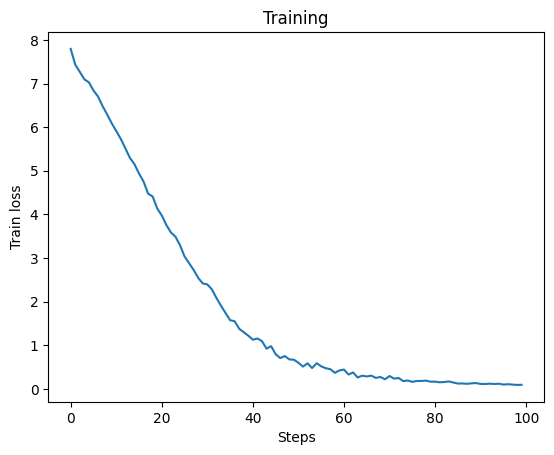

In [17]:
# Define X and Y variable data
x = np.array(list(range(len(train_loss_history))))
y = np.array(train_loss_history)

plt.plot(x, y)
plt.xlabel("Steps")  # add X-axis label
plt.ylabel("Train loss")  # add Y-axis label
plt.title("Training")  # add title
plt.show()

# Make batches for inference

In [18]:
transformer.eval()
src_batch, trg_batch, labels_batch = generate_batch(64)

In [19]:
preds_batch = torch.zeros_like(labels_batch)

In [20]:
# predict from first token
trg_batch[:,1:] = torch.full(trg_batch[:,1:].shape, 0)

# Inference

In [22]:
# generating cycle
for i in range(trg_batch.shape[1]):
    res = transformer(src_batch.to(device), trg_batch.to(device))
    preds_batch[:,i] = res[:,i].argmax(dim=1)

    if i < trg_batch.shape[1]-1:
        trg_batch[:,i+1] = res[:,i].argmax(dim=1)

In [23]:
preds_batch

tensor([[467, 469, 471,  ..., 561, 563, 565],
        [495, 497, 499,  ..., 589, 591, 593],
        [414, 416, 418,  ..., 508, 510, 512],
        ...,
        [193, 195, 197,  ..., 287, 289, 291],
        [140, 142, 144,  ..., 234, 236, 238],
        [ 49,  51,  53,  ..., 143, 145, 147]])

In [24]:
trg_batch

tensor([[465, 467, 469,  ..., 559, 561, 563],
        [493, 495, 497,  ..., 587, 589, 591],
        [412, 414, 416,  ..., 506, 508, 510],
        ...,
        [191, 193, 195,  ..., 285, 287, 289],
        [138, 140, 142,  ..., 232, 234, 236],
        [ 47,  49,  51,  ..., 141, 143, 145]])

# Compare labels and preds here

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [26]:
preds = preds_batch.view(-1).cpu().numpy()
labels = labels_batch.view(-1).cpu().numpy()

accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average='weighted')
recall = recall_score(labels, preds, average='weighted')
f1 = f1_score(labels, preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
